<a href="https://colab.research.google.com/github/herozandn/rede_neural/blob/main/Rede_Neural_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [159]:
import numpy as np

In [160]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("oddrationale/mnist-in-csv")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'mnist-in-csv' dataset.
Path to dataset files: /kaggle/input/mnist-in-csv


In [161]:
# Carregando datasets
data_teste = np.loadtxt("/content/sample_data/mnist_test.csv", delimiter=",")
data_treino = np.loadtxt("/content/sample_data/mnist_train_small.csv", delimiter=",")

# Separa as etiquetas dos valores dos pixels
x_treino = data_treino[:, 1:]
y_treino = data_treino[:, 0]

x_teste = data_teste[:, 1:]
y_teste = data_teste[:, 0]

# Formato das matrizes
print(f'Formato dos dados de treino: ', x_treino.shape)
print(f'Formato dos dados de treino: ', y_treino.shape)

print(f'Formato dos dados de teste: ', x_teste.shape)
print(f'Formato dos dados de teste: ', y_teste.shape)

Formato dos dados de treino:  (20000, 784)
Formato dos dados de treino:  (20000,)
Formato dos dados de teste:  (10000, 784)
Formato dos dados de teste:  (10000,)


#Pré-processando dados

1. **Normalizar:** Os valores de pixel variam de 0 a 255. É fundamental normalizá-los para um intervalo entre 0 e 1, dividindo cada valor por 255.
2. **One-hot Encoding:** As etiquetas (0, 1, 2, ..., 9) precisam ser convertidas para um formato one-hot encoding. Por exemplo, o dígito '3' se torna um vetor [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]. Isso é necessário para que a saída da rede neural seja um vetor de probabilidades.

1. **Normalização dos Pixels**  
Os valores dos pixels variam de 0 (preto) a 255 (branco). Para o treinamento da rede neural, é essencial que os dados de entrada estejam entre 0 e 1.

In [162]:
#Normalizando os valores
x_treino = x_treino/255
x_teste = x_teste/255

2. **Codificação One-Hot das Etiquetas**  
As etiquetas de saída devem ser vetores binários (one-hot) de 10 elementos (um para cada dígito). Por exemplo, a etiqueta 5 deve se tornar [0, 0, 0, 0, 0, 1, 0, 0, 0, 0].

In [163]:
def one_hot_encoding(y, num_classes=10):
  # Cria uma matriz de 0 com o número de linhas igual a y.size e número de
  #colunas igual a 10
  one_hot_y = np.zeros((y.size, num_classes))

  one_hot_y[np.arange(y.size), y.astype(int)] = 1
  return one_hot_y.T

In [164]:
y_train_encoded = one_hot_encoding(y_treino)
y_train_encoded[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [165]:
y_test_encoded = one_hot_encoding(y_teste)
y_test_encoded[0]

array([0., 0., 0., ..., 0., 0., 0.])

# Arquitetura e Inicialização de parâmetros

Vamos construir uma rede neural simples com **três camadas** (duas ocultas e uma de saída)

**A. Definição da Arquitetura:**
Precisamos definir o número de neurônios em cada camada:

**Camada de Entrada** (Layer 0): 784 neurônios (o tamanho achatado da sua imagem 28×28).

**Camada Oculta 1** (Layer 1): Um bom ponto de partida é 128.

**Camada Oculta 2** (Layer 2): 64 neurônios.

**Camada de Saída** (Layer 2): 10 neurônios (um para cada dígito, de 0 a 9).

**B. Inicialização Aleatória:**
A inicialização dos pesos é essencial para quebrar a simetria e permitir que a rede comece a aprender. Usaremos pequenos valores aleatórios e bias (vieses) zerados.

Onde:

*W
[1]*
 : Pesos da Camada 1 (Oculta) – forma (128
 , 784)

*B
[1]*
 : Bias da Camada 1 – forma (128
 , 1)

*W
[2]*
 : Pesos da Camada 2 (Oculta) – forma (64, 128
 )

*B
[2]*
 : Bias da Camada 2 – forma (64, 1)

 *W
[3]*
 : Pesos da Camada 3 (Saída) – forma (10, 64
 )

*B
[3]*
 : Bias da Camada 3 – forma (10, 1)

**Observação**: Faremos as operações matriciais pensando nos vetores de entrada como colunas.  
Portanto, vamos transpor os dados de entrada para que tenham a forma correta para os cálculos: (784,N).

In [166]:
# Transpor a matriz de entrada para uma coluna e 784 linhas
x_treino = x_treino.T
x_teste = x_teste.T

def inicializar_parametros(ent_tam, cam_ocu1, cam_ocu2, cam_sai):
  W1 = np.random.randn(cam_ocu1, ent_tam) * 0.01
  B1 = np.zeros((cam_ocu1, 1))

  W2 = np.random.randn(cam_ocu2, cam_ocu1) * 0.01
  B2 = np.zeros((cam_ocu2, 1))

  W3 = np.random.randn(cam_sai, cam_ocu2) * 0.01
  B3 = np.zeros((cam_sai, 1))

  parametros = {
      "W1":W1, "B1":B1,
      "W2":W2, "B2":B2,
      "W3":W3, "B3":B3
  }

  return parametros

# Função de ativação

Agora precisamos das funções que darão a capacidade de aprendizado não-linear à sua rede.  
* **A. ReLU (Camada Oculta)**.  
A função Rectified Linear Unit (ReLU) e sua derivada:$$A = \max(0, Z)$$  

* **B. Softmax (Camada de Saída).**  
A função Softmax converte os logits (saídas da camada final) em probabilidades que somam 1.$$A^{[2]}_i = \frac{e^{Z^{[2]}_i}}{\sum_{j} e^{Z^{[2]}_j}}$$

In [167]:
def relu(Z):
  return np.maximum(0, Z)

def relu_derivada(A):
    return (A>0).astype(int)

def softmax(Z):
  Z_stabilized = Z - np.max(Z, axis=0, keepdims=True)

  exp_Z = np.exp(Z_stabilized)
  return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

# Propagação para frente

A função **feedforward** recebe os parâmetros da camada anterior, realiza a operação de produto interno, adiciona um viés e aplica a **função de ativação**.

In [168]:
def propagacao_frente(x, parametros):
  # Acessando parâmetros
  W1 = parametros["W1"]
  W2 = parametros["W2"]
  W3 = parametros["W3"]
  B1 = parametros["B1"]
  B2 = parametros["B2"]
  B3 = parametros["B3"]

  # Camada 1
  Z1 = W1 @ x + B1
  A1 = relu(Z1)

  # Camada 2
  Z2 = W2 @ A1 + B2
  A2 = relu(Z2)

  # Camada 3
  Z3 = W3 @ A2 + B3
  A3 = softmax(Z3)

  cache = {"Z1" : Z1, "A1" : A1, "Z2" : Z2, "A2" : A2, "Z3": Z3, "A3": A3}
  return A3, cache

# Retropropagação

A função de **retropropagação** receberá o dicionário de parâmetros e os cache da etapa Forward para calcular os _gradientes_.

Com este código, temos as derivadas prontas para atualizar os parâmetros!

In [169]:
def retropropagacao(x, y, parametros, cache):

  # Tamanho do lote
  m = x.shape[1]

  # Acessando parâmetros
  W3 = parametros["W3"]
  A1 = cache["A1"]
  Z1 = cache["Z1"]
  A2 = cache["A2"]
  A3 = cache["A3"]
  Z2 = cache["Z2"]
  W2 = parametros["W2"]

  # Derivada CAMADA 3
  dZ3 = A3 - y

  # Derivada CAMADA 3, antes da função de ativação, W3
  dW3 = dZ3 @ A2.T / m

  # Derivada do viés da CAMADA 3
  dB3 = np.sum(dZ3, axis=1, keepdims=True) / m

  # Derivada CAMADA 2
  dZ2 = W3.T @ dZ3 * relu_derivada(Z2)

  # Derivada CAMADA 2, antes da função de ativação, W2
  dW2 = dZ2 @ A1.T / m

  # Derivada do viés da CAMADA 2
  dB2 = np.sum(dZ2, axis=1, keepdims=True) / m

   # Derivada CAMADA 1
  dZ1 = W2.T @ dZ2 * relu_derivada(Z1)

  # Derivada CAMADA 1, antes da função de ativação, W1
  dW1 = dZ1 @ x.T / m

  # Derivada do viés da CAMADA 1
  dB1 = np.sum(dZ1, axis=1, keepdims=True) / m

  # Retornar os parâmetros
  grads = {"dW1":dW1,
          "dW2":dW2,
          "dW3":dW3,
          "dB1":dB1,
          "dB2":dB2,
          "dB3":dB3}

  return grads

# Atualização de parâmetros

A função de Atualização (Descida de Gradiente) é a única que modifica os parâmetros. Ela recebe os parâmetros e os gradientes, e retorna os parâmetros atualizados.

In [170]:
def atualizar_parametros(parametros, grads, taxa_aprendizado):
    W1 = parametros["W1"]
    B1 = parametros["B1"]
    W2 = parametros["W2"]
    B2 = parametros["B2"]
    W3 = parametros["W3"]
    B3 = parametros["B3"]

    dW1 = grads["dW1"]
    dB1 = grads["dB1"]
    dW2 = grads["dW2"]
    dB2 = grads["dB2"]
    dW3 = grads["dW3"]
    dB3 = grads["dB3"]

    # Atualizar os parâmetros a partir do gradiente
    parametros["W1"] = W1 - taxa_aprendizado * dW1
    parametros["W2"] = W2 - taxa_aprendizado * dW2
    parametros["W3"] = W3 - taxa_aprendizado * dW3
    parametros["B1"] = B1 - taxa_aprendizado * dB1
    parametros["B2"] = B2 - taxa_aprendizado * dB2
    parametros["B3"] = B3 - taxa_aprendizado * dB3

    return parametros

# Função Custo

O valor do custo ($J$) deve ser calculado em uma função separada e é crucial por **dois motivos:**  
1. **Monitoramento:** O custo é a métrica principal que você usa para saber se sua rede está, de fato, aprendendo. Se o custo diminuir a cada época, o treinamento está indo bem.  
2. **Separação de Responsabilidades:** O cálculo do custo é a parte do Forward Pass (Propagação para Frente) que não é uma derivada, enquanto a Retropropagação só lida com derivadas (gradientes).

In [171]:
def funcao_custo(y_train_encoded, A3):

  m = y_train_encoded.shape[1]
  epsilon = 1e-8
  A3_clipped = np.clip(A3, epsilon, 1-epsilon)

  custo = -np.sum(y_train_encoded*np.log(A3_clipped)) / m

  return custo

# Treinamento

In [172]:
def treino(x_treino, y_train_encoded, y_treino):

  # Número de neurônios
  cam_ent = x_treino.shape[0]
  # Neurônios camada oculta 1
  cam_ocu1 = 128
  # Neurônios camada oculta 2
  cam_ocu2 = 64
  # Neurônios da camada de saída
  cam_sai = 10

  parametros = inicializar_parametros(cam_ent, cam_ocu1, cam_ocu2, cam_sai)
  taxa_aprendizado = 0.0158
  num_epocas = 60
  num_pac = 64

  N_SAMPLES = x_treino.shape[1] # Total de amostras

  cost_history = []
  accuracy_history = []

  for epoca in range(num_epocas):

    custo_total = 0

    # Cria um array de índices e embaralha para garantir que a rede não veja a mesma ordem
    permutation = np.random.permutation(N_SAMPLES)
    X_shuffled = x_treino[:, permutation]
    Y_shuffled = y_train_encoded[:, permutation]

    for i in range(0, N_SAMPLES, num_pac):
        # Define o lote atual
        X_batch = X_shuffled[:, i:i + num_pac]
        Y_batch = Y_shuffled[:, i:i + num_pac]

        # Forward propagation

        A3, cache = propagacao_frente(X_batch, parametros)

        # Custo
        custo = funcao_custo(Y_batch, A3)
        custo_total += custo

        # Retropropagação
        grads = retropropagacao(X_batch, Y_batch, parametros, cache)

        # Atualização parâmetros
        parametros = atualizar_parametros(parametros, grads, taxa_aprendizado)

    # Calcula o custo médio da época
    avg_cost = custo_total / (N_SAMPLES / num_pac)
    cost_history.append(avg_cost)
    # Opcional: Calcular a precisão no conjunto de treino (para monitoramento)
    A3_train, _ = propagacao_frente(x_treino, parametros)
    predictions = np.argmax(A3_train, axis=0)

    # Y_train_T[0] é o label real (0 a 9)
    accuracy = np.mean(predictions == y_treino) * 100
    accuracy_history.append(accuracy)
    print(f"Época {epoca+1}/{num_epocas}: Custo Médio: {avg_cost:.4f}, Precisão: {accuracy:.2f}%")
  print("\nTreinamento concluído!")
  return parametros

# Pondo à prova

1. **Carregar os dados de teste:**  
Já carreguei os dados no início do código, só irei transpô-los agora

2. **Implementando a Função de Predição e Precisão:**  
Utilizamos somente a propagação para testar o modelo

In [173]:
def predicoes(X, parametros):

  A3, _ = propagacao_frente(X, parametros)

  # retorna a maior probabilidade em cada coluna
  predicoes = np.argmax(A3, axis=0)
  return predicoes

def acuracia(predicoes, y_test):

  acuracia = np.mean(predicoes == y_test) * 100
  return acuracia

3. **Avaliando o conjunto:**  
Utilizando o modelo treinado, vamos conferir sua precisão

In [174]:
final = treino(x_treino, y_train_encoded, y_treino)

Época 1/60: Custo Médio: 2.3055, Precisão: 11.21%
Época 2/60: Custo Médio: 2.3045, Precisão: 11.21%
Época 3/60: Custo Médio: 2.3035, Precisão: 11.21%
Época 4/60: Custo Médio: 2.3019, Precisão: 11.21%
Época 5/60: Custo Médio: 2.2959, Precisão: 20.38%
Época 6/60: Custo Médio: 2.2436, Precisão: 23.28%
Época 7/60: Custo Médio: 2.0501, Precisão: 37.66%
Época 8/60: Custo Médio: 1.6081, Precisão: 57.02%
Época 9/60: Custo Médio: 1.1701, Precisão: 66.72%
Época 10/60: Custo Médio: 0.9108, Precisão: 75.24%
Época 11/60: Custo Médio: 0.7259, Precisão: 79.47%
Época 12/60: Custo Médio: 0.6416, Precisão: 81.15%
Época 13/60: Custo Médio: 0.5880, Precisão: 83.53%
Época 14/60: Custo Médio: 0.5379, Precisão: 85.28%
Época 15/60: Custo Médio: 0.4916, Precisão: 86.53%
Época 16/60: Custo Médio: 0.4548, Precisão: 87.39%
Época 17/60: Custo Médio: 0.4273, Precisão: 88.25%
Época 18/60: Custo Médio: 0.4068, Precisão: 88.37%
Época 19/60: Custo Médio: 0.3887, Precisão: 89.08%
Época 20/60: Custo Médio: 0.3722, Precis

In [175]:
predicao_final = predicoes(x_teste, final)

acuracia_total = acuracia(predicao_final, y_teste)

print("--- Resultado Final ---")
print(f"Precisão Final no Conjunto de Teste: {acuracia_total:.2f}%")

--- Resultado Final ---
Precisão Final no Conjunto de Teste: 95.45%


In [176]:
nome = "modelo_mnist_final.npy"
np.save(nome, final, allow_pickle=True)

# Visualizar

In [177]:
import matplotlib.pyplot as plt
import random

In [178]:
def visualizar_dados(x, largura=28, altura=28):
  imagem_2d = x.reshape(largura, altura)

  plt.imshow(imagem_2d, interpolation='nearest', cmap='grey')
  plt.title("Imagem processada")
  plt.show()

def analisar(x_teste, y_teste, indice, parametros):
  x_selecionado = x_teste[: , indice].reshape(-1,1)
  y_selecionado = y_teste[indice]

  A3, _ = propagacao_frente(x_selecionado, parametros)
  previsao = np.argmax(A3)
  probabilidade = A3.T[0]

  return x_selecionado.flatten(), previsao, y_selecionado, probabilidade

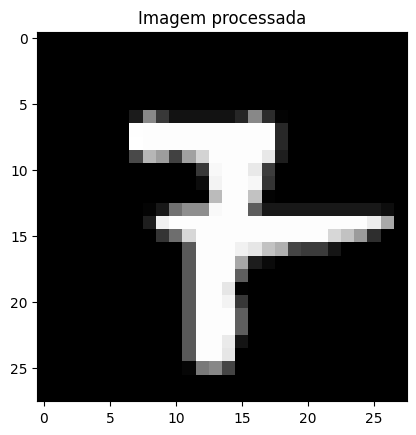

Predição: 7
Rótulo: 7.0


In [189]:
indice = 97
x, previsao, y_real, probs = analisar(x_teste, y_teste, indice, final)
visualizar_dados(x)
print(f'Predição: {previsao}')
print(f'Rótulo: {y_real}')